In [1]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl
%config IPCompleter.greedy=True
import pandas_datareader
import urllib3


In [2]:
### fecthing country names from IMF database to get all ISO codes
countrycodes = pd.read_csv('coucodes.csv', delimiter = ';', encoding = "ISO-8859-1")
countrycodes = countrycodes[["IMF Name", "ISO Code", "ISO2 Code"]]
countrycodes.reset_index(level=0, inplace=True)
countrycodes = countrycodes.rename(columns={'IMF Name': 'country'})

In [3]:
#downloading data from worldbank

from pandas_datareader import wb

worldbank_data = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_", "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 2010, end = 2020, freq = "M")
worldbank_data2 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1999, end = 2009, freq = "M")
worldbank_data3 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_","IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1990, end = 1998, freq = "M")

worldbank_data = pd.concat([worldbank_data, worldbank_data2])
worldbank_data = pd.concat([worldbank_data, worldbank_data3])

worldbank_data.reset_index(inplace=True)

worldbank_data_conc = pd.merge(worldbank_data, countrycodes, on="country")


In [4]:
#Get missing data per country. This is the basic data that will be used, so we will define a arbitrary maximum threshold of missing values.

def count_missing(frame):
    return (frame.shape[0] * frame.shape[1]) - frame.count().sum()

nan_by_country = worldbank_data_conc.groupby("country").apply(count_missing)

#Threshold
selected_countries = nan_by_country[nan_by_country < 1500]
selected_countries

country
Algeria            1147
Argentina           642
Armenia            1331
Australia           452
Austria             705
Bangladesh         1447
Belgium             133
Bolivia            1450
Brazil              238
Bulgaria            976
Canada              134
Chile               474
China               670
Colombia            805
Costa Rica         1315
Croatia            1020
Cyprus             1445
Czech Republic      417
Denmark             363
Ecuador            1145
El Salvador        1413
Estonia             468
Finland             170
France              147
Germany             134
Greece              632
Hungary             417
Iceland            1197
India               895
Indonesia           621
                   ... 
Morocco            1382
Netherlands          61
New Zealand        1184
Nigeria            1482
Norway              457
Oman               1462
Pakistan            967
Peru                244
Philippines         137
Poland              207
Portugal

In [18]:
countrylist = pd.DataFrame(selected_countries)

In [19]:
countrylist.head()

,0
country,
Algeria,1147
Argentina,642
Armenia,1331
Australia,452
Austria,705


In [21]:
countrylist.to_csv('countrylist.csv')

In [5]:
#Subsetting the original data based on the definition above
selected_worldbank_data = worldbank_data_conc[worldbank_data_conc["country"].isin(selected_countries.index)]

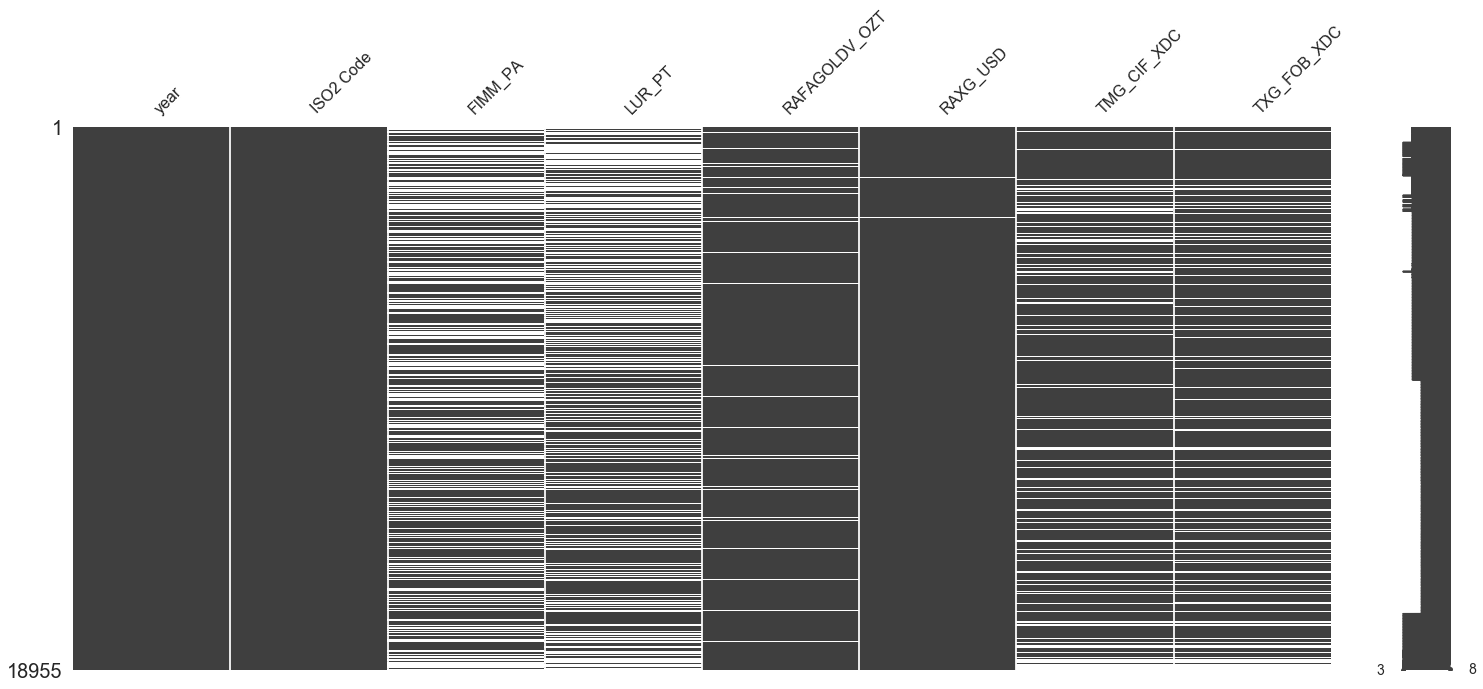

In [6]:
# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

#FOr now we are removing Ireland because an aparent error of the api
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/M.AR+AU+AT+BE+BR+BG+CA+CL+CH+CO+HR+CZ+DK+EE+FI+FR+DE+GR+HK+HU+IN+ID+IS+IT+JP+JO+KR+LV+LU+MY+MX+NL+NO+PK+PE+PH+PL+PT+NA+RU+SA+SG+SK+SL+ZA+ES+SE+CH+TH+TN+TR+UG+GB+US+VE.RAFAGOLDV_OZT+RAXG_USD+LUR_PT+TXG_FOB_XDC+TMG_CIF_XDC+FIMM_PA.?startPeriod=1990&endPeriod=2020'

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)
stack["@TIME_PERIOD"] = stack["@TIME_PERIOD"].str.replace("-", "M")

stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
msno.matrix(stack)

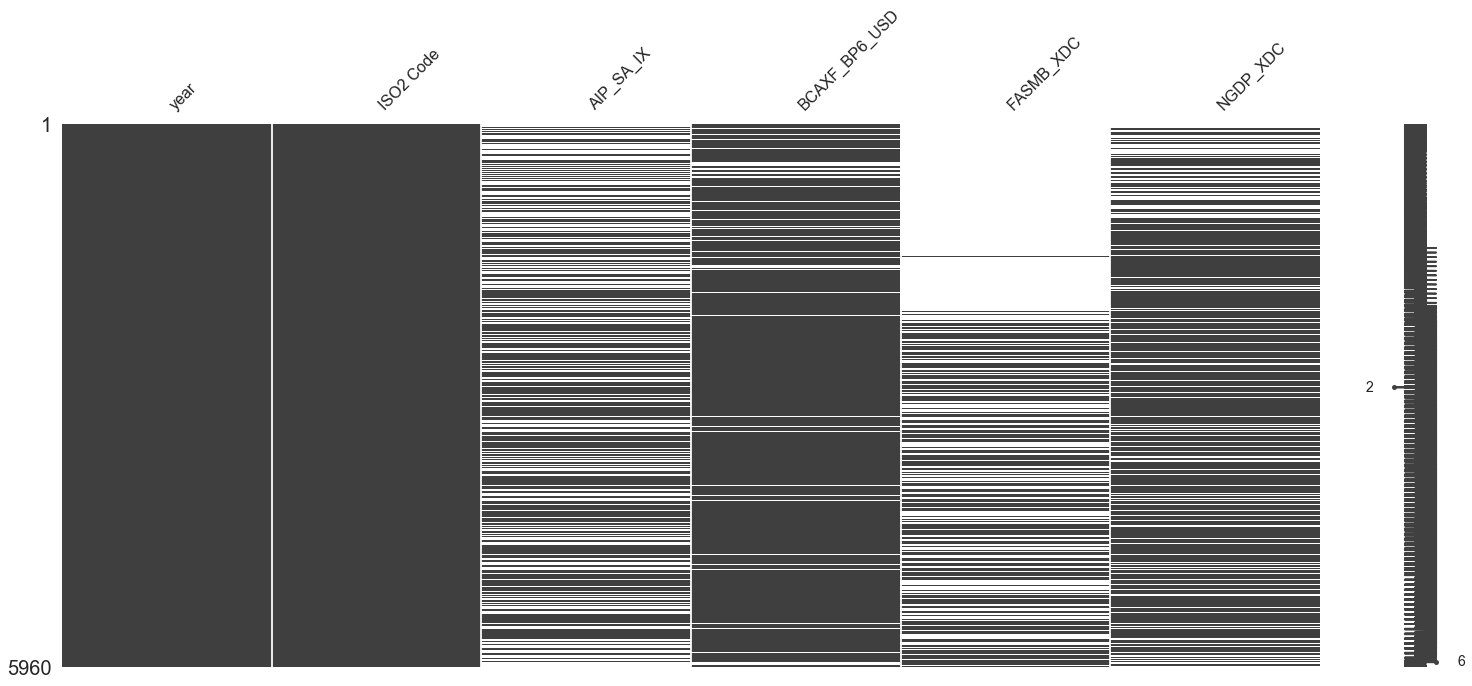

In [7]:
#Quarterly data

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q.AR+AU+AT+BE+BR+BG+CA+CL+CH+CO+HR+CZ+DK+EE+FI+FR+DE+GR+HK+HU+IN+ID+IS+IT+JP+JO+KR+LV+LU+MY+MX+NL+NO+PK+PE+PH+PL+PT+NA+RU+SA+SG+SK+SL+ZA+ES+SE+CH+TH+TN+TR+UG+GB+US+VE.AIP_SA_IX+NGDP_XDC+PCTOT+BCAXF_BP6_USD+FASMB_XDC.?startPeriod=1990&endPeriod=2020'


# Get data from the above URL using the requests package
data = requests.get(url).json()

#### stacking IMF data and creating a dataframe
stackq = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stackq.append(data2)
stackq = pd.concat(stackq)


stackq = stackq.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stackq.columns = stackq.columns.droplevel(0)

stackq.reset_index(inplace=True)
stackq["@TIME_PERIOD"] = stackq["@TIME_PERIOD"].str.replace("-", "")

stackq = stackq.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
msno.matrix(stackq)

In [8]:
stackq["year"] = pd.to_datetime(stackq["year"])

#stackq2 = stackq.set_index('year', 'ISO2 Code').groupby('ISO2 Code').resample("M")
stack_q = stackq.set_index('year').groupby('ISO2 Code').resample("M").last()
stack_q = stack_q.drop(columns=["ISO2 Code"])

In [9]:
#Interpolation method 1 - Back
stack_q.bfill().head(10)


indicator                    AIP_SA_IX BCAXF_BP6_USD FASMB_XDC NGDP_XDC
ISO2 Code year                                                         
AR        1990-01-31  74.0370185092547           922     26899   212627
          1990-02-28  74.0370185092547          1070     26899   212627
          1990-03-31  74.0370185092547          1070     26899   212627
          1990-04-30  74.0370185092547          1070     26899   212627
          1990-05-31  74.0370185092547          1703     26899   212627
          1990-06-30  74.0370185092547          1703     26899   212627
          1990-07-31  74.0370185092547          1703     26899   212627
          1990-08-31  74.0370185092547           857     26899   212627
          1990-09-30  74.0370185092547           857     26899   212627
          1990-10-31  74.0370185092547           857     26899   212627

In [10]:
#Interpolation method 2 - Same within the quarterly

stack_q.ffill().head(10)


indicator            AIP_SA_IX BCAXF_BP6_USD FASMB_XDC NGDP_XDC
ISO2 Code year                                                 
AR        1990-01-31       NaN           922       NaN      NaN
          1990-02-28       NaN           922       NaN      NaN
          1990-03-31       NaN           922       NaN      NaN
          1990-04-30       NaN          1070       NaN      NaN
          1990-05-31       NaN          1070       NaN      NaN
          1990-06-30       NaN          1070       NaN      NaN
          1990-07-31       NaN          1703       NaN      NaN
          1990-08-31       NaN          1703       NaN      NaN
          1990-09-30       NaN          1703       NaN      NaN
          1990-10-31       NaN           857       NaN      NaN

In [11]:
#Method 3 - Linear interpolation

for col in stack_q:
    stack_q[col] = pd.to_numeric(stack_q[col], errors='coerce')

stack_q.interpolate().head(10)


indicator             AIP_SA_IX  BCAXF_BP6_USD  FASMB_XDC  NGDP_XDC
ISO2 Code year                                                     
AR        1990-01-31        NaN     922.000000        NaN       NaN
          1990-02-28        NaN     971.333333        NaN       NaN
          1990-03-31        NaN    1020.666667        NaN       NaN
          1990-04-30        NaN    1070.000000        NaN       NaN
          1990-05-31        NaN    1281.000000        NaN       NaN
          1990-06-30        NaN    1492.000000        NaN       NaN
          1990-07-31        NaN    1703.000000        NaN       NaN
          1990-08-31        NaN    1421.000000        NaN       NaN
          1990-09-30        NaN    1139.000000        NaN       NaN
          1990-10-31        NaN     857.000000        NaN       NaN

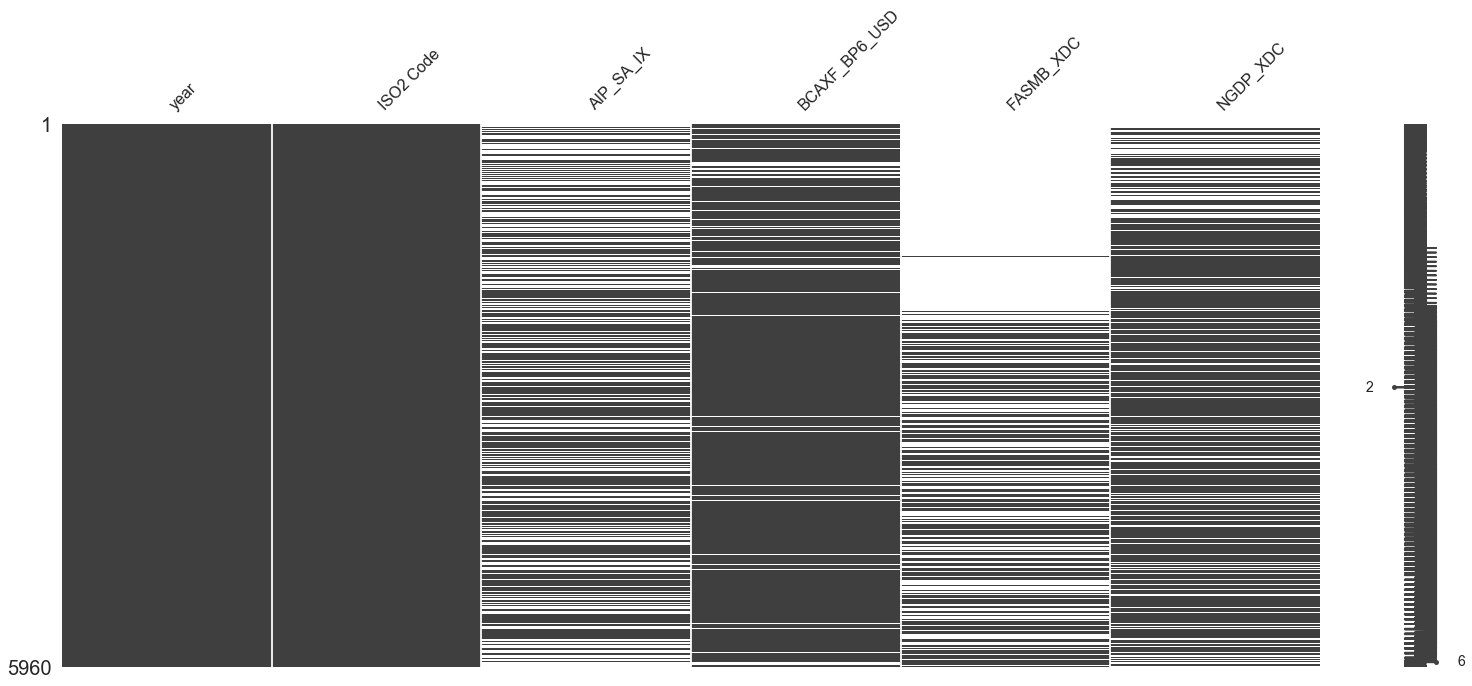

In [12]:
msno.matrix(stackq)

In [13]:
stackq.index = pd.to_datetime(stackq["year"])

stackq.resample("M")
stackq


indicator,year,ISO2 Code,AIP_SA_IX,BCAXF_BP6_USD,FASMB_XDC,NGDP_XDC
year,,,,,,
1990-01-01,1990-01-01,AR,NaN,922,NaN,NaN
1990-01-01,1990-01-01,AU,73.809336953817,-4676.54174790981,NaN,97616
1990-01-01,1990-01-01,BE,65.2839738228315,NaN,NaN,NaN
1990-01-01,1990-01-01,BR,NaN,-2722,NaN,NaN
1990-01-01,1990-01-01,CA,81.8945384582388,-8270.19257540655,NaN,165931
1990-01-01,1990-01-01,CH,66.7456486034132,NaN,NaN,87231.131956
1990-01-01,1990-01-01,DE,78.1384824652247,18424.7777142519,NaN,NaN
1990-01-01,1990-01-01,DK,NaN,-97.5644677162862,NaN,NaN
1990-01-01,1990-01-01,ES,94.838741634304,-4478.06335521752,NaN,NaN


In [14]:
### Merging IMF and WB database
full_data = selected_worldbank_data.join(stack, how = "left")


ValueError: columns overlap but no suffix specified: Index(['year', 'ISO2 Code'], dtype='object')

In [ ]:
full_data.head()


In [15]:
stack.head()

indicator,year,ISO2 Code,FIMM_PA,LUR_PT,RAFAGOLDV_OZT,RAXG_USD,TMG_CIF_XDC,TXG_FOB_XDC
0,1990M01,AR,18312.701620051,NaN,4.373,1325.45891990774,64.7245086,128.0229977
1,1990M01,AT,NaN,6.9,20.583,8270.80622497945,3412.71629252269,2634.39023858491
2,1990M01,AU,17.8063636363636,6.4,7.933,13544.7710440807,NaN,3684
3,1990M01,BE,NaN,7,30.2554374909576,10914.3905458787,NaN,NaN
4,1990M01,BR,49023.3720998911,NaN,3.027,7807.7109334818,0.0116309427152226,0.0141212246170306
